## Generating Explanation using TreeSurrogate (Classification/Regression)

### 1. Classification example using Iris dataset

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)
X = df
y = iris.target

In [2]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=5, class_weight="balanced", oob_score=True, random_state=1)
clf.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [3]:
clf.feature_importances_

array([0.33239175, 0.03907281, 0.38180386, 0.24673158])

In [4]:
y_hat_train = clf.predict(X_train)
y_hat = clf.predict(X_test)

In [5]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        31
    class 1       0.97      0.97      0.97        35
    class 2       0.97      0.97      0.97        34

avg / total       0.98      0.98      0.98       100


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       1.00      1.00      1.00        15
    class 2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



In [6]:
print(np.unique(y_hat))
print(np.unique(y_test))

[0 1 2]
[0 1 2]


In [7]:
from skater.core.explanations import Interpretation
#from skater.core.global_interpretation.tree_surrogate import TreeSurrogate
from skater.util.dataops import show_in_notebook

interpreter = Interpretation(X_train, feature_names=iris.feature_names)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(estimator_type='classifier', 
                                                 feature_names=iris.feature_names, 
                                                 class_names=iris.target_names, seed=5)

In [13]:
# Using the surrogate model learn the decision boundaries learned by the base estimator
# Also report fidelity value when compared to the base estimator
# Learner uses F1 metric as the default metric of choice for classification.
surrogate_explainer.learn(X_train, y_hat_train, oracle_y=y_train, cv=5)

2018-08-21 06:35:58,629 - skater.model.base - WARNING - No examples provided, cannot infer model type


8.403361344555549e-06

In [14]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], file_name='simple_tree.png')

2018-08-21 06:36:01,745 - skater.util.dataops - INFO - File Name: simple_tree.png


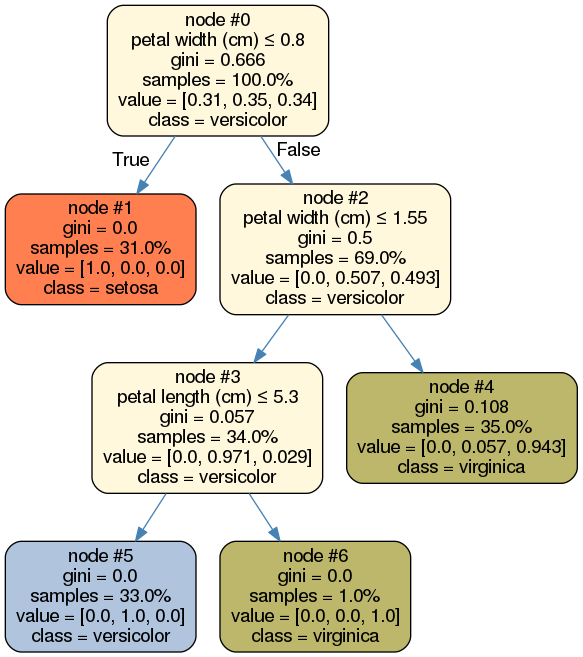

In [15]:
show_in_notebook('simple_tree.png', width=400, height=300)

In [16]:
surrogate_explainer.decisions_as_txt()

if petal width (cm) <= 0.800000011920929 {
    Predicted Label: 0
} else {
  if petal width (cm) <= 1.5499999523162842 {
    if petal length (cm) <= 5.300000190734863 {
        Predicted Label: 1
    } else {
        Predicted Label: 2
    }
  } else {
      Predicted Label: 2
  }
}


#### Evaluating individual prediction

In [17]:
sample_index = 6
X_test.iloc[sample_index]

sepal length (cm)    5.6
sepal width (cm)     2.9
petal length (cm)    3.6
petal width (cm)     1.3
Name: 64, dtype: float64

In [18]:
print("Oracle Model {}:".format(clf.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [1]:
Using TreeSurrogate [1]:


In [19]:
surrogate_explainer.decisions_as_txt('local', X_test.iloc[sample_index])

As petal width (cm)[1.3] > 0.800000011920929 then,
  As petal width (cm)[1.3] <= 1.5499999523162842 then,
    As petal length (cm)[3.6] <= 5.300000190734863 then,
        Predicted Label: 1


### 2. Regression example

In [20]:
from sklearn.datasets import load_boston
from sklearn.ensemble.forest import RandomForestRegressor
boston = load_boston()

# Create a dataframe with the four feature variables
df = pd.DataFrame(boston.data, columns=boston.feature_names)
X = df
y = boston.target

# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

est = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)
est.fit(X_train, y_train)

y_hat_reg_train = est.predict(X_train)
y_hat_reg = est.predict(X_test)


print("Train Evaluation ...")
from sklearn.metrics import r2_score
print(r2_score(y_train, y_hat_reg_train))

print("Test Evaluation ...")
# Using R^2(Coefficient of Determination for evaluation)
from sklearn.metrics import r2_score
print(r2_score(y_test, y_hat_reg))

Train Evaluation ...
0.9644396137293327
Test Evaluation ...
0.8241067799403498


In [21]:
interpreter_reg = Interpretation(X_train, feature_names=boston.feature_names)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer_reg = interpreter_reg.tree_surrogate(estimator_type='regressor',
                                                         feature_names=boston.feature_names, seed=5)

In [30]:
# The score returned is the fidelity score = difference in performance between the values returned by the Oracle and
# the surrogate model. If the difference is big then the surrogate model most likely is not a good representation
# of the base model.
surrogate_explainer_reg.learn(X_train, y_hat_reg_train, n_iter_search=10, oracle_y=y_train, scorer_type='r2', cv=2)

2018-08-21 06:37:02,281 - skater.model.base - WARNING - No examples provided, cannot infer model type
2018-08-21 06:37:02,283 - skater.core.global_interpretation.tree_surrogate - WARNING - fidelity score:0.11997066550696434 of the surrogate model is higher than the impurity threshold: 0.01


0.11997066550696434

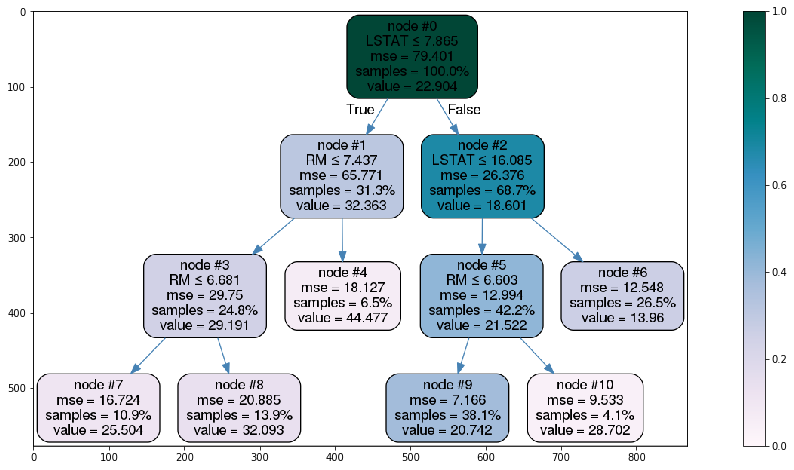

In [31]:
%matplotlib inline
surrogate_explainer_reg.plot_global_decisions(file_name='simple_tree_reg.png')

2018-08-21 06:37:08,681 - skater.util.dataops - INFO - File Name: simple_tree_reg.png


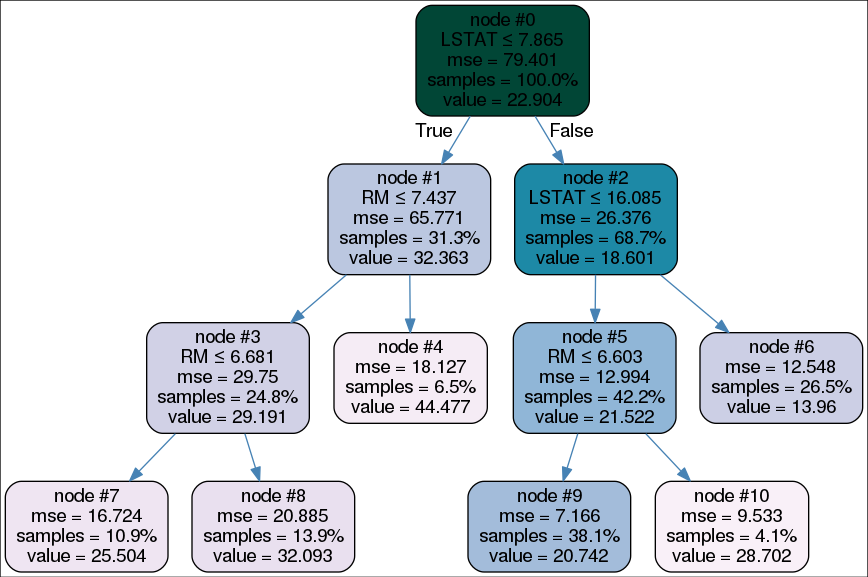

In [32]:
show_in_notebook('simple_tree_reg.png')

#### Evaluating individual prediction

In [33]:
sample_index = 6
X_test.iloc[sample_index]

CRIM         0.31827
ZN           0.00000
INDUS        9.90000
CHAS         0.00000
NOX          0.54400
RM           5.91400
AGE         83.20000
DIS          3.99860
RAD          4.00000
TAX        304.00000
PTRATIO     18.40000
B          390.70000
LSTAT       18.33000
Name: 316, dtype: float64

In [34]:
print("Oracle Model {}:".format(est.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer_reg.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [20.03]:
Using TreeSurrogate [13.96]:


In [35]:
surrogate_explainer_reg.decisions_as_txt('local', X_test.iloc[sample_index])

As LSTAT[18.33] > 7.864999771118164 then,
  As LSTAT[18.33] > 16.084999084472656 then,
      Value: [[13.96]]
